# 02 几何变换

## 简介 
该部分将对基本的几何变换进行学习，几何变换的原理大多都是相似，只是变换矩阵不同，因此，我们以最常用的平移和旋转为例进行学习。在深度学习领域，我们常用平移、旋转、镜像等操作进行数据增广；在传统CV领域，由于某些拍摄角度的问题，我们需要对图像进行矫正处理，而几何变换正是这个处理过程的基础，因此了解和学习几何变换也是有必要的。

这次我们带着几个问题进行，以旋转为例：
* 1：变换的形式（公式）是什么？

* 2：旋转中心是什么？毕竟以不同位置为旋转中心得到的结果是不一样的。

* 3：采用前向映射还是反向映射？(反向映射更为有效)

* 4：采用反向映射后，采用何种插值算法？最常用的的是双线性插值，OpenCV也是默认如此。


## 算法理论介绍
### 变换形式
先看第一个问题，变换的形式。与OpencV不同的是这里采取冈萨雷斯的《数字图像处理_第三版》的变换矩阵方式，关于OpenCV的策略可以看它的官方文档。根据冈萨雷斯书中的描述，仿射变换的一般形式如下：  
 ![Image](https://img-blog.csdnimg.cn/20200413000257295.png)  
 
式中的T就是变换矩阵，其中 (v,w)为原坐标，(x,y) 为变换后的坐标，不同的变换对应不同的矩阵，这里也贴出来吧，一些常见的变换矩阵及作用如下表：  

![Image](https://img-blog.csdnimg.cn/20200413000334168.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3dlaXhpbl80MDY0NzgxOQ==,size_16,color_FFFFFF,t_70) 

也就是说，我们根据自己的目的选择不同变换矩阵就可以了。

### 坐标系变换
再看第二个问题，变换中心，对于缩放、平移可以以图像坐标原点（图像左上角为原点）为中心变换，这不用坐标系变换，直接按照一般形式计算即可。而对于旋转和偏移，一般是以图像中心为原点，那么这就涉及坐标系转换了。

我们都知道，图像坐标的原点在图像左上角，水平向右为 X 轴，垂直向下为 Y 轴。数学课本中常见的坐标系是以图像中心为原点，水平向右为 X 轴，垂直向上为 Y 轴，称为笛卡尔坐标系。看下图:  


   ![Image](https://img-blog.csdnimg.cn/20200413000533449.png)  
   
因此，对于旋转和偏移，就需要3步（3次变换）：

* 将输入原图图像坐标转换为笛卡尔坐标系；
* 进行旋转计算。旋转矩阵前面已经给出了；
* 将旋转后的图像的笛卡尔坐标转回图像坐标。

### 图像坐标系与笛卡尔坐标系转换关系：

先看下图：  

![](imgs/20200413002920287.png)

在图像中我们的坐标系通常是AB和AC方向的,原点为A，而笛卡尔直角坐标系是DE和DF方向的，原点为D。
**令图像表示为M×N的矩阵，对于点A而言，两坐标系中的坐标分别是(0，0)和(-N/2,M/2)，则图像某像素点(x',y')转换为笛卡尔坐标（x,y）转换关系为，x为列，y为行：**   

![](imgs/20200413004600511.png)  

逆变换为：  

![](imgs/2020041300453767.png)  

于是，根据前面说的3个步骤（3次变换），旋转(顺时针旋转)的变换形式就为，3次变换就有3个矩阵：  

![](imgs/20200413005411233.png)  

### 反向映射  
看第3个问题，在冈萨雷斯的《数字图像处理_第三版》中说的很清楚，前向映射就是根据原图用变换公式直接算出输出图像相应像素的空间位置，那么这会导致一个问题：可能会有多个像素坐标映射到输出图像的同一位置，也可能输出图像的某些位置完全没有相应的输入图像像素与它匹配，也就是没有被映射到，造成有规律的空洞（黑色的蜂窝状）。更好的一种方式是采用 反向映射（Inverse Mapping）：扫描输出图像的位置(x,y)，通过
![](imgs/20200413005247477.png)
（为T的逆矩阵）计算输入图像对应的位置 (v,w)，通过插值方法决定输出图像该位置的灰度值。

###  插值
第4个问题，采用反向映射后，需通过插值方法决定输出图像该位置的值，因此需要选择插值算法。通常有最近邻插值、双线性插值，双三次插值等，OpencV默认采用双线性插值，我们也就采用双线性插值。

## 基于OpenCV的实现(Pythong)

In [1]:
#引入响应的包
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

### 变换

OpenCV提供了两个转换函数**cv.warpAffine**和**cv.warpPerspective**，您可以使用它们进行各种转换。**cv.warpAffine**采用2x3转换矩阵，而**cv.warpPerspective**采用3x3转换矩阵作为输入。

### 缩放

缩放只是调整图像的大小。为此，OpenCV带有一个函数**cv.resize()。图像的大小可以手动指定，也可以指定缩放比例。也可使用不同的插值方法。首选的插值方法是**cv.INTER_AREA**用于缩小，**cv.INTER_CUBIC（慢）和**cv.INTER_LINEAR**用于缩放。默认情况下，出于所有调整大小的目的，使用的插值方法为**cv.INTER_LINEAR**。您可以使用以下方法调整输入图像的大小：

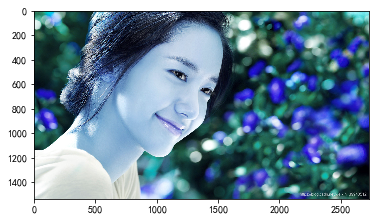

In [2]:
img = cv.imread('images/yun.jpg')
res = cv.resize(img,None,fx=2, fy=2, interpolation = cv.INTER_CUBIC)
plt.imshow(res)

### 平移

平移是物体位置的移动。如果您知道在(x,y)方向上的位移，则将其设为(t_x,t_y)，你可以创建转换矩阵\mathbf{M}，如下所示：

M = \begin{bmatrix} 1 & 0 & t_x \\ 0 & 1 & t_y \end{bmatrix}
您可以将其放入**np.float32**类型的Numpy数组中，并将其传递给**cv.warpAffine**函数。参见下面偏移为(100, 50)的示例：

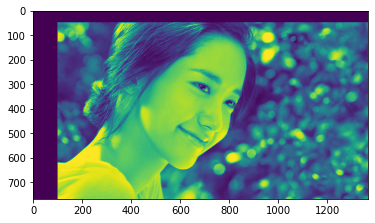

In [4]:
img = cv.imread('images/yun.jpg',0)
rows,cols = img.shape
M = np.float32([[1,0,100],[0,1,50]])
dst = cv.warpAffine(img,M,(cols,rows))
plt.imshow(dst)
cv.waitKey(0)
cv.destroyAllWindows()

### 旋转

图像旋转角度为θ是通过以下形式的变换矩阵实现的：

M = \begin{bmatrix} cos\theta & -sin\theta \\ sin\theta & cos\theta \end{bmatrix}
但是OpenCV提供了可缩放的旋转以及可调整的旋转中心，因此您可以在自己喜欢的任何位置旋转。修改后的变换矩阵为

\begin{bmatrix} \alpha & \beta & (1- \alpha ) \cdot center.x - \beta \cdot center.y \\ - \beta & \alpha & \beta \cdot center.x + (1- \alpha ) \cdot center.y \end{bmatrix}
其中：

\begin{array}{l} \alpha = scale \cdot \cos \theta , \\ \beta = scale \cdot \sin \theta \end{array}
为了找到此转换矩阵，OpenCV提供了一个函数**cv.getRotationMatrix2D**。请检查以下示例，该示例将图像相对于中心旋转90度而没有任何缩放比例。

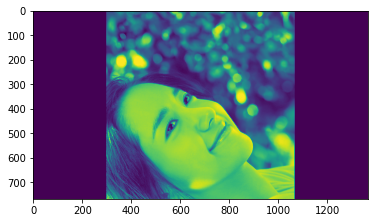

In [5]:
img = cv.imread('images/yun.jpg',0)
rows,cols = img.shape
# cols-1 和 rows-1 是坐标限制
M = cv.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),90,1)
dst = cv.warpAffine(img,M,(cols,rows))
plt.imshow(dst)

### 仿射变换

在仿射变换中，原始图像中的所有平行线在输出图像中仍将平行。为了找到变换矩阵，我们需要输入图像中的三个点及其在输出图像中的对应位置。然后**cv.getAffineTransform**将创建一个2x3矩阵，该矩阵将传递给**cv.warpAffine**。

查看以下示例，并查看我选择的点（以绿色标记）：

(<AxesSubplot:title={'center':'Output'}>,
 Text(0.5, 1.0, 'Output'))

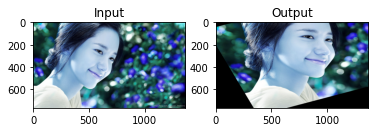

In [6]:
img = cv.imread('images/yun.jpg')
rows,cols,ch = img.shape
pts1 = np.float32([[50,50],[200,50],[50,200]])
pts2 = np.float32([[10,100],[200,50],[100,250]])
M = cv.getAffineTransform(pts1,pts2)
dst = cv.warpAffine(img,M,(cols,rows))
plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')

### 透视变换

对于透视变换，您需要3x3变换矩阵。即使在转换后，直线也将保持直线。要找到此变换矩阵，您需要在输入图像上有4个点，在输出图像上需要相应的点。在这四个点中，其中三个不应共线。然后可以通过函数**cv.getPerspectiveTransform**找到变换矩阵。然后将**cv.warpPerspective**应用于此3x3转换矩阵。

请参见下面的代码：

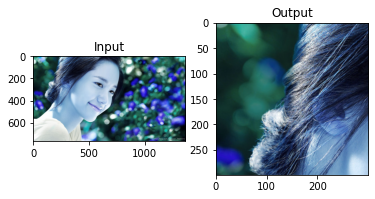

In [7]:
img = cv.imread('images/yun.jpg')
rows,cols,ch = img.shape
pts1 = np.float32([[56,65],[368,52],[28,387],[389,390]])
pts2 = np.float32([[0,0],[300,0],[0,300],[300,300]])
M = cv.getPerspectiveTransform(pts1,pts2)
dst = cv.warpPerspective(img,M,(300,300))
plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()